In [67]:
import os.path
import math
import re
import tensorflow as tf
import numpy as np
import facenet
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth, Birch
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import time
%matplotlib inline

In [184]:
def get_model_filenames(model_dir):
    files = os.listdir(model_dir)
    meta_files = [s for s in files if s.endswith('.meta')]
    if len(meta_files)==0:
        raise ValueError('No meta file found in the model directory (%s)' % model_dir)
    elif len(meta_files)>1:
        raise ValueError('There should not be more than one meta file in the model directory (%s)' % model_dir)
    meta_file = meta_files[0]
    meta_files = [s for s in files if '.ckpt' in s]
    max_step = -1
    for f in files:
        step_str = re.match(r'(^model-[\w\- ]+.ckpt-(\d+))', f)
        if step_str is not None and len(step_str.groups())>=2:
            step = int(step_str.groups()[1])
            if step > max_step:
                max_step = step
                ckpt_file = step_str.groups()[0]
    return meta_file, ckpt_file

def load_model(model, sess):
    model_exp = os.path.expanduser(model)
    print('Model directory: %s' % model_exp)
    meta_file, ckpt_file = get_model_filenames(model_exp)

    print('Metagraph file: %s' % meta_file)
    print('Checkpoint file: %s' % ckpt_file)

    saver = tf.train.import_meta_graph(os.path.join(model_exp, meta_file))
    saver.restore(sess, os.path.join(model_exp, ckpt_file))
    
def forward(paths, batch_size):
    nrof_images = len(paths)
    nrof_batches = int(math.ceil(1.0*nrof_images / batch_size))
    emb_array = np.zeros((nrof_images, embedding_size))

    for i in range(nrof_batches):    
        start_index = i*batch_size
        end_index = min((i+1)*batch_size, nrof_images)
        paths_batch = paths[start_index:end_index]
        images = facenet.load_data(paths_batch, False, False, image_size)
        feed_dict = { images_placeholder:images, phase_train_placeholder:False }
        emb_array[start_index:end_index,:] = sess.run(embeddings, feed_dict=feed_dict)    
        print("batch number:", i)
    print("Complete")
    
    return emb_array

def printDistance(emb_array, label_list, end=10):
    threshold = 1.0
    lng = len(emb_array[:end])
    print('Distance matrix')
    print('    ', end='')
    for i in range(lng):
        print('    %3d     ' % i, end='')
    print('')
    for i in range(lng):
        print('%1d  ' % i, end='')
        for j in range(lng):
            dist = np.linalg.norm(emb_array[i,:] - emb_array[j,:])
            print('  %1.4f' % dist, end='')
            if (label_list[i] == label_list[j]) and (dist <= threshold):
                print("(TP)", end='')
            elif (label_list[i] != label_list[j]) and (dist > threshold):
                print("(TN)", end='')
            elif (label_list[i] == label_list[j]) and (dist > threshold):
                print("\033[93m(FN)\033[0m", end='')
            elif (label_list[i] != label_list[j]) and (dist <= threshold):
                print("\033[93m(FP)\033[0m", end='')
        print('')
        
def printData(labels, paths, number):
    for i in range(number):
        if i > 0 and labels[i] != labels[i-1]:
            print('')
        print('{0:3d} {1:3d}   {2:s}'.format(i, labels[i], paths[i].split("\\")[1]))
        # print('{0:3d}   {1:s}'.format(labels[i], paths[i].split("\\")[1]))
        
def PCAtransform(emb_array, n_components = 10):
    pca = PCA(n_components, whiten=True)
    pca.fit(emb_array)
    return pca.transform(emb_array), pca

def splitTrainTest(data_set, percent_train):
    paths, labels_list = facenet.get_image_paths_and_labels(data_set)
    
    lng = len(paths)
    lng_train = int(lng * percent_train / 100);
    lng_test = lng - lng_train
    
    train_paths = paths[0:lng_train]
    test_paths = paths[lng_train:]
    
    train_labels = labels_list[0:lng_train]
    test_labels = labels_list[lng_train:]
    
    return train_paths, train_labels, test_paths, test_labels

def preprocessing(X, num_components = 50):
    num_features = X.shape[1]
    
    X = X - np.mean(X, axis=0) # centering
    X = X / X.std(axis=0) # standardization

    # PCA
    cov = np.cov(X.T)
    eig_vals, eig_vecs = np.linalg.eig(cov)

    for ev in eig_vecs:
        np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))

    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs.sort()
    eig_pairs.reverse()

    pca_matrix = eig_pairs[0][1].reshape(num_features, 1)

    for i in range(1, num_components):
        pca_matrix = np.hstack((pca_matrix,
                                eig_pairs[i][1].reshape(num_features, 1)))

    X = X.dot(pca_matrix)

    # Whitening
    X = X / np.sqrt(eig_vals[:num_components])
    
    return X
    

def trainFisher(emb_array, y):
    emb_del = np.empty_like(emb_array)
    np.copyto(emb_del, emb_array)
    
    emb_array = np.vstack((emb_array, y))
    
    E = np.linalg.inv(np.cov(emb_array.T))
    D = (y - (1 / (len(emb_array) - 1) * np.sum(emb_del)))
    
    w = np.dot(E, D)
    c = np.dot(w / np.linalg.norm(w), y)
    
    return c, w

def trainFisherWithNum(emb_array, sample_number):    
    y = emb_array[sample_number]
    emb_del = np.delete(emb_array, (sample_number), axis=0)
    
    E = np.linalg.inv(np.cov(emb_array.T))
    D = (y - (1 / (len(emb_array) - 1) * np.sum(emb_del)))
    
    w = np.dot(E, D)
    c = np.dot(w / np.linalg.norm(w), y)
    
    return c, w   

def Fisher(w, c, sample):
    return np.dot(w / np.linalg.norm(w), sample) - c

In [3]:
sess = tf.Session()
data_set = facenet.get_dataset("../../datasets/lfw/lfw_mtcnnpy_160/")
train_paths, train_labels, test_paths, test_labels = splitTrainTest(data_set, 100)
load_model("20170511-185253", sess)

images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")

image_size = 160
embedding_size = embeddings.get_shape()[1]

Model directory: 20170511-185253
Metagraph file: model-20170511-185253.meta
Checkpoint file: model-20170511-185253.ckpt-80000
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from 20170511-185253\model-20170511-185253.ckpt-80000


In [12]:
emb_array = np.load('embeddings.npy')

In [15]:
t = emb_array

# Centering
tc = t - np.mean(t, axis=0)

# Standartization
ts = tc / tc.std(axis=0)

# PCA
X = ts

num_components = 50

cov = np.cov(X.T)
eig_vals, eig_vecs = np.linalg.eig(cov)

for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything is ok!')

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

pca_matrix = eig_pairs[0][1].reshape(128, 1)

for i in range(1, num_components):
    pca_matrix = np.hstack((pca_matrix,
                            eig_pairs[i][1].reshape(128, 1)))

X_pca = X.dot(pca_matrix)

# Whitening
X_whit = X_pca / np.sqrt(eig_vals[:num_components])

Everything ok!


**Fisher's discriminant**

In [527]:
bush_label = 5
idx, = np.where(train_labels == bush_label)

X_work = np.delete(X_whit, idx, axis=0)
c, w = trainFisher(X_work, X_whit[idx[0]])

lng = len(X_whit)
summ = 0
thr = 0.0
answers = []

for i in range(lng):
    l = Fisher(w, thr, X_whit[i]/np.linalg.norm(X_whit[i]))
    answers.append(l)
    
answers = np.asarray(answers)
true_labels = np.array(train_labels == bush_label, dtype=int)
prediction = np.array(answers > 0, dtype=int)

print("Precision: ", metrics.precision_score(true_labels, prediction))
print("Recall:    ", metrics.recall_score(true_labels, prediction))

Precision:  0.000616998303255
Recall:     1.0


**FN and FP**

In [528]:
fn = len(prediction[idx][prediction[idx] != true_labels[idx]])
fnr = fn / len(true_labels[idx])

print("Elements:             ", len(prediction[idx]))
print("False Negatives:      ", fn)
print("False Negatives Rate: ", fnr)
print("")

idx2, = np.where(train_labels != bush_label)
fp = len(prediction[idx2][prediction[idx2] != true_labels[idx2]])
fpr = fp / len(true_labels[idx2])

print("Elements:             ", len(prediction[idx2]))
print("False Positives:      ", fp)
print("False Positives Rate: ", fpr)

Elements:              4
False Negatives:       0
False Negatives Rate:  0.0

Elements:              13229
False Positives:       6479
False Positives Rate:  0.48975735127371683


**Plots**

(array([ 1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.]),
 array([ 0.58292861,  0.61800747,  0.65308632,  0.68816517,  0.72324403,
         0.75832288,  0.79340174,  0.82848059,  0.86355945,  0.8986383 ,
         0.93371715]),
 <a list of 10 Patch objects>)

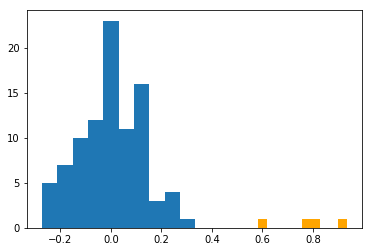

In [530]:
plt.hist(answers[4:100][true_labels[4:100] == 0], histtype="bar")
plt.hist(answers[4:100][true_labels[4:100] == 1], histtype="bar", color='orange')

In [493]:
answers[4:10]

array([-0.05724639,  0.93371715,  0.77620345,  0.79686176,  0.58292861,
        0.03708661])

In [495]:
answers[4:10][true_labels[4:10] == 1]

array([ 0.93371715,  0.77620345,  0.79686176,  0.58292861])

In [496]:
answers[4:10][true_labels[4:10] == 0]

array([-0.05724639,  0.03708661])